In [1]:
pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


### **Data Loading and Pre processing**

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="yO3WR28GRrSzenR57zne")
project = rf.workspace("imit-h5ows").project("soil-detection-l0ngo")
dataset = project.version(1).download("yolov8")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-detection-1 in yolov8:: 100%|██████████| 582/582 [00:00<00:00, 3190.54it/s]


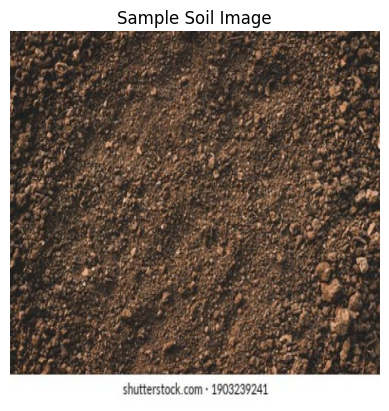

In [3]:
import cv2
import matplotlib.pyplot as plt
import random
import os

img_dir = "Soil-detection-1/train/images"
img = random.choice(os.listdir(img_dir))

img_data = cv2.imread(f"{img_dir}/{img}")
plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
plt.title("Sample Soil Image")
plt.axis(False)
plt.show()


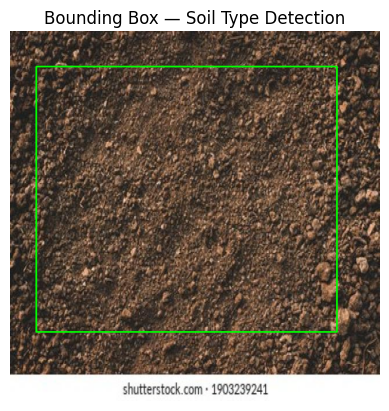

In [4]:
import cv2
import matplotlib.pyplot as plt

img_path = f"{img_dir}/{img}"
label_path = f"Soil-detection-1/train/labels/{img.replace('.jpg', '.txt')}"

img_data = cv2.imread(img_path)
h, w, _ = img_data.shape

with open(label_path) as f:
    lines = f.readlines()

for l in lines:
    cls, x, y, bw, bh = map(float, l.split())
    x1 = int((x - bw/2) * w)
    y1 = int((y - bh/2) * h)
    x2 = int((x + bw/2) * w)
    y2 = int((y + bh/2) * h)

    cv2.rectangle(img_data, (x1, y1), (x2, y2), (0,255,0), 2)

plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
plt.title("Bounding Box — Soil Type Detection")
plt.axis(False)
plt.show()


In [5]:
import cv2
import os
from tqdm import tqdm
import numpy as np
import random

input_dir = "Soil-detection-1/train/images"
output_dir = "processed_soil_train"
os.makedirs(output_dir, exist_ok=True)

def preprocess(img):
    # Resize
    img = cv2.resize(img, (640, 640))

    # Random flip
    if random.random() < 0.3:
        img = cv2.flip(img, 1)

    # Random brightness
    if random.random() < 0.3:
        factor = 1 + (random.random() - 0.5) * 0.4
        img = cv2.convertScaleAbs(img, alpha=factor, beta=0)

    # Normalize (0–1)
    img = img / 255.0

    return img

for img_name in tqdm(os.listdir(input_dir)):
    path = os.path.join(input_dir, img_name)
    img = cv2.imread(path)
    if img is None:
        continue

    processed = preprocess(img)
    processed = (processed * 255).astype("uint8")  # convert back to save

    cv2.imwrite(os.path.join(output_dir, img_name), processed)


100%|██████████| 199/199 [00:08<00:00, 22.94it/s]


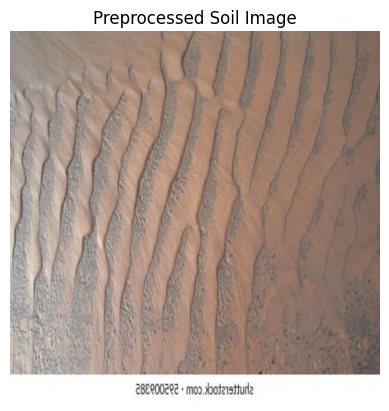

In [6]:
import random
import matplotlib.pyplot as plt

img = random.choice(os.listdir(output_dir))
img_data = cv2.imread(f"{output_dir}/{img}")

plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
plt.title("Preprocessed Soil Image")
plt.axis(False)
plt.show()


In [14]:
import yaml

with open("Soil-detection-1/data.yaml") as f:
    data = yaml.safe_load(f)

class_names = data["names"]
print("Classes:", class_names)



Classes: ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil']


In [18]:
import os
import shutil
from tqdm import tqdm
base_out = "soil_classification"

# ✅ Create directory structure
for split in ["train", "val"]:
    for cls in class_names:
        os.makedirs(f"{base_out}/{split}/{cls}", exist_ok=True)

def convert_split(split_name):
    img_dir = f"Soil-detection-1/{split_name}/images"
    lbl_dir = f"Soil-detection-1/{split_name}/labels"
    out_dir = f"{base_out}/{'train' if split_name=='train' else 'val'}"

    for lbl_file in tqdm(os.listdir(lbl_dir), desc=f"Processing {split_name}"):
        lbl_path = os.path.join(lbl_dir, lbl_file)

        # Skip empty label files
        if os.path.getsize(lbl_path) == 0:
            continue

        with open(lbl_path) as f:
            lines = f.readlines()

        # Take first label as dominant soil
        class_id = int(lines[0].split()[0])
        class_name = class_names[class_id]

        img_name = lbl_file.replace(".txt", ".jpg")
        img_path = os.path.join(img_dir, img_name)

        if not os.path.exists(img_path):
            continue

        shutil.copy(
            img_path,
            os.path.join(out_dir, class_name, img_name)
        )

# ✅ Run conversion
convert_split("train")
convert_split("valid")

print("✅ Conversion completed successfully")

Processing valid: 100%|██████████| 58/58 [00:00<00:00, 2525.56it/s]

✅ Conversion completed successfully


In [20]:
for split in ["train", "val"]:
    print(f"\n{split.upper()} SET")
    for cls in class_names:
        count = len(os.listdir(f"soil_classification/{split}/{cls}"))
        print(f"{cls}: {count} images")



TRAIN SET
Alluvial Soil: 64 images
Black Soil: 55 images
Clay Soil: 29 images
Red Soil: 51 images

VAL SET
Alluvial Soil: 18 images
Black Soil: 17 images
Clay Soil: 9 images
Red Soil: 14 images


## **Bounding Box Visualization**

In [7]:
import cv2
import os
import matplotlib.pyplot as plt

image_dir = "Soil-detection-1/train/images"
label_dir = "Soil-detection-1/train/labels"

def draw_bboxes(img_path, label_path):
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, x, y, bw, bh = map(float, line.split())

        # YOLO → pixel conversion
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, f"Class {int(cls)}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    return img


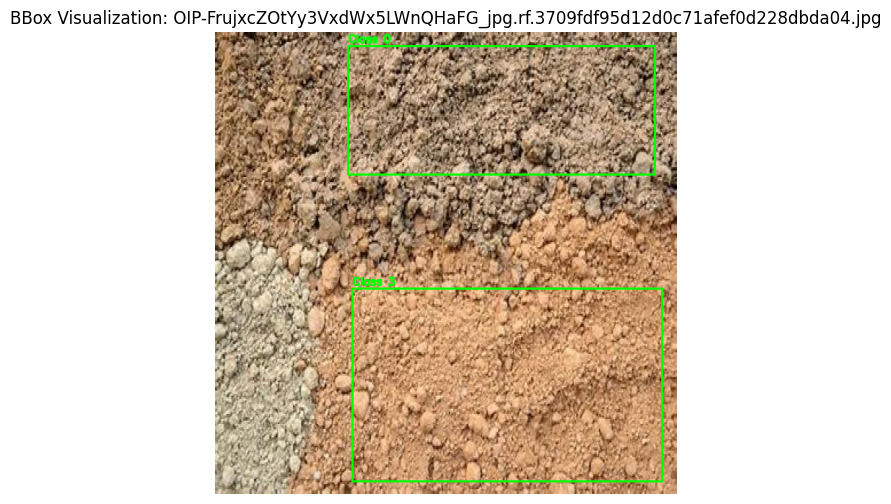

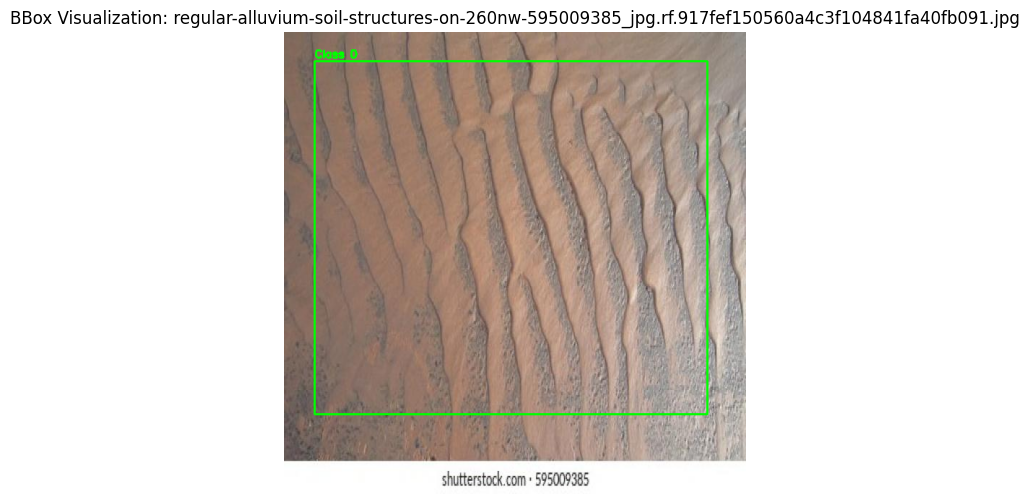

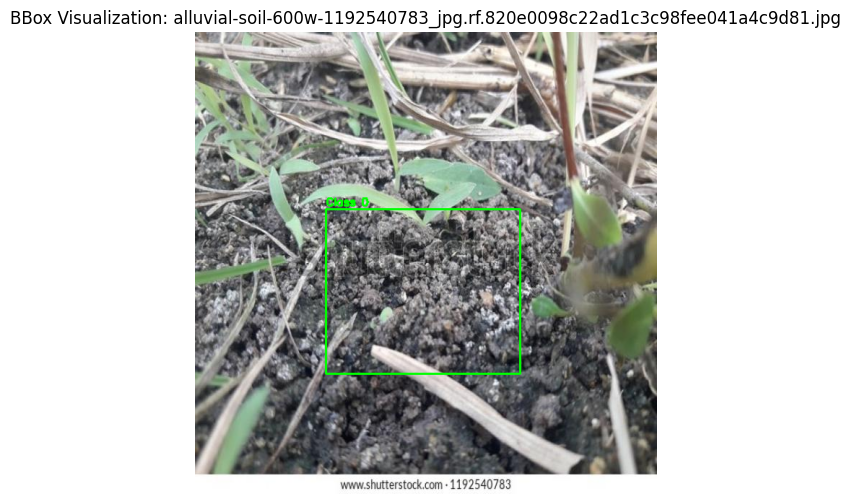

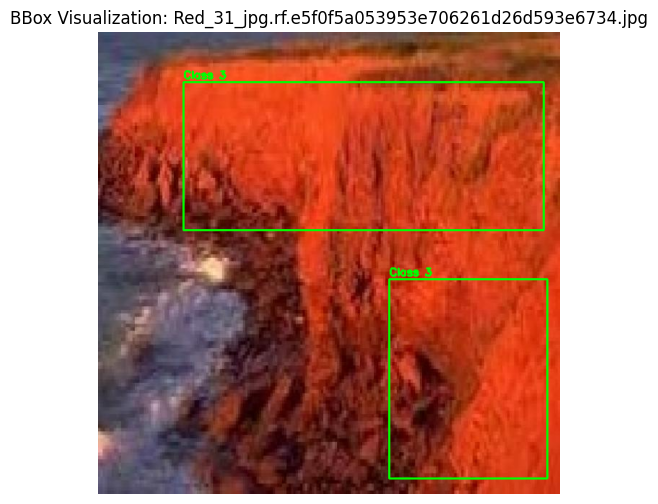

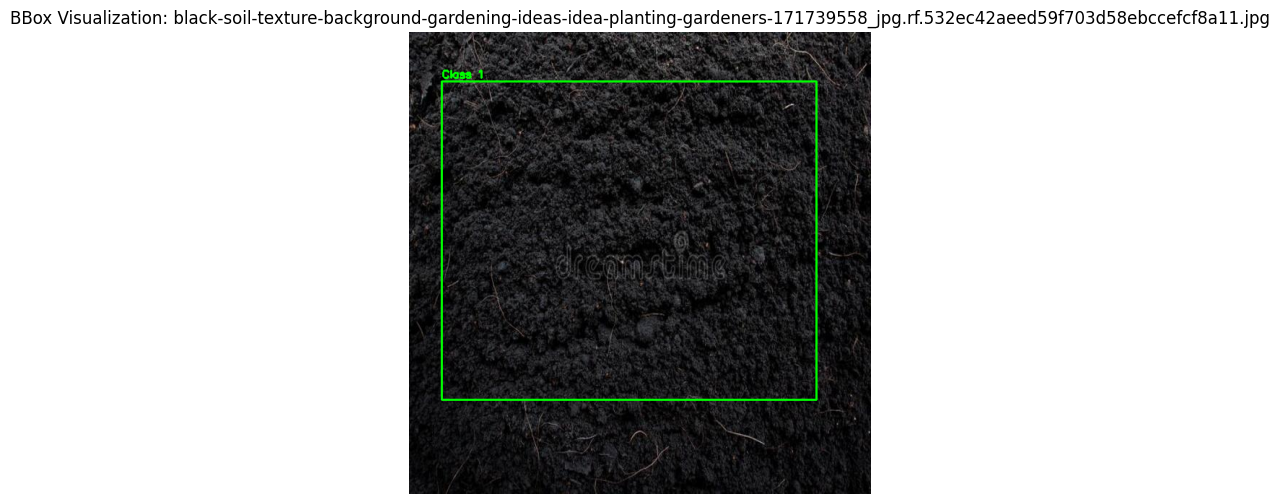

In [8]:

sample_images = os.listdir(image_dir)[:5]

for img_name in sample_images:
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))

    if not os.path.exists(label_path):
        continue

    img = draw_bboxes(img_path, label_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"BBox Visualization: {img_name}")
    plt.axis("off")
    plt.show()

## **Class Distribution Analysis**

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

label_dir = "Soil-detection-1/train/labels"
class_counts = Counter()

for label_file in os.listdir(label_dir):
    with open(os.path.join(label_dir, label_file)) as f:
        for line in f:
            cls_id = int(line.split()[0])
            class_counts[cls_id] += 1

print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples")


Class Distribution:
Class 0: 78 samples
Class 1: 60 samples
Class 2: 30 samples
Class 3: 75 samples


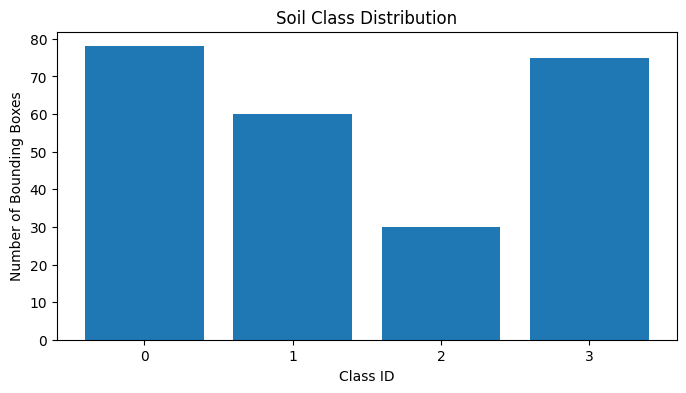

In [10]:
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(8,4))
plt.bar(classes, counts)
plt.xlabel("Class ID")
plt.ylabel("Number of Bounding Boxes")
plt.title("Soil Class Distribution")
plt.xticks(classes)
plt.show()


In [11]:
empty_labels = []

for label_file in os.listdir(label_dir):
    path = os.path.join(label_dir, label_file)
    if os.path.getsize(path) == 0:
        empty_labels.append(label_file)

print("Empty label files:", len(empty_labels))


Empty label files: 0


## **Train Valid Check**

In [12]:
train_images = set(os.listdir("Soil-detection-1/train/images"))
val_images   = set(os.listdir("Soil-detection-1/valid/images"))

leakage = train_images.intersection(val_images)

print(f"Total Train Images: {len(train_images)}")
print(f"Total Val Images: {len(val_images)}")
print(f"Data Leakage Found: {len(leakage)}")

if leakage:
    print("Leaked Images:", list(leakage)[:5])
else:
    print("✅ No data leakage detected")


Total Train Images: 199
Total Val Images: 58
Data Leakage Found: 0
✅ No data leakage detected


## **Base Line Training**

In [13]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.0 MB/s eta 0:00:00


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [47]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    channel_shift_range=40.0,   # 🔥 IMPORTANT
    shear_range=0.25,
    horizontal_flip=True,
    fill_mode="nearest"
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "soil_classification/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    "soil_classification/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 199 images belonging to 4 classes.
Found 58 images belonging to 4 classes.


In [23]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [27]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)



Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2318 - loss: 1.5255 - val_accuracy: 0.3103 - val_loss: 1.3281
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4206 - loss: 1.2935 - val_accuracy: 0.4138 - val_loss: 1.3188
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - accuracy: 0.4554 - loss: 1.2849 - val_accuracy: 0.4310 - val_loss: 1.2867
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4838 - loss: 1.2739 - val_accuracy: 0.3276 - val_loss: 1.2896
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.3966 - loss: 1.2521 - val_accuracy: 0.4138 - val_loss: 1.2601
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.5144 - loss: 1.2557 - val_accuracy: 0.3966 - val_loss: 1.2564
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.5026 - loss: 1.2187 - val_accuracy: 0.4310 - val_loss: 1.2488
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4943 - loss: 1.2039 - val_accuracy: 0.43

In [28]:
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3468 - loss: 1.2597
Validation Accuracy: 0.414


In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img("test_soil.jpg", target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = pred.argmax()

print("Predicted Soil Type:", list(train_data.class_indices.keys())[class_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Soil Type: Alluvial Soil


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


<Figure size 600x600 with 0 Axes>

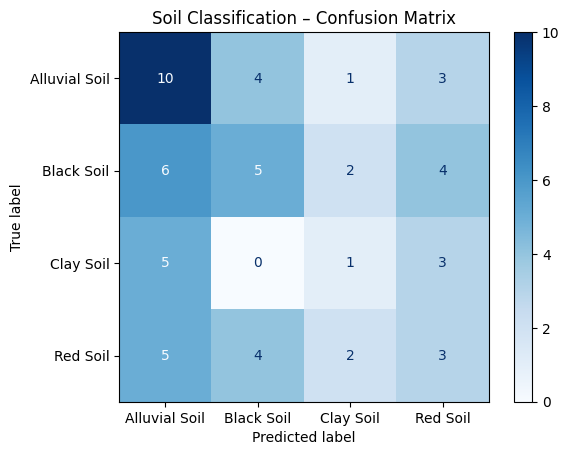

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels
y_true = val_data.classes

# Get predictions
y_pred_prob = model.predict(val_data)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Soil Classification – Confusion Matrix")
plt.show()


## **Tunning Configuration**

Problems:
1. Underfitting
2. Low capicity
3. Soil Simiilarity

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


In [50]:

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights
)


Class weights: {0: np.float64(0.77734375), 1: np.float64(0.9045454545454545), 2: np.float64(1.7155172413793103), 3: np.float64(0.9754901960784313)}
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.5011 - loss: 1.1575 - val_accuracy: 0.3966 - val_loss: 1.4741
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 646ms/step - accuracy: 0.7006 - loss: 0.8848 - val_accuracy: 0.3448 - val_loss: 1.6026
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.6982 - loss: 0.8625 - val_accuracy: 0.3276 - val_loss: 1.7319
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.6797 - loss: 0.8755 - val_accuracy: 0.3276 - val_loss: 1.6527
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.6923 - loss: 0.9347 - val_accuracy: 0.3621 - val_loss: 1.6933
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step - accuracy: 0.7779 - loss: 0.7942 - val_accuracy: 0.3793 - val_loss: 1.6524
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.6387 - loss: 0.893

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


<Figure size 640x480 with 0 Axes>

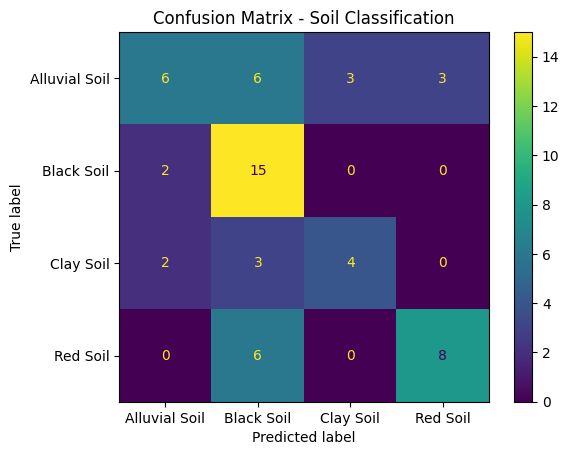

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels
y_true = val_data.classes

# Get predictions
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure()
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(val_data.class_indices.keys())
)
disp.plot()
plt.title("Confusion Matrix - Soil Classification")
plt.show()


In [52]:
import numpy as np

class_names = list(val_data.class_indices.keys())

per_class_acc = {}

for i, class_name in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i].sum()
    acc = correct / total if total > 0 else 0
    per_class_acc[class_name] = acc

print("Per-class accuracy:")
for cls, acc in per_class_acc.items():
    print(f"{cls}: {acc:.2f}")


Per-class accuracy:
Alluvial Soil: 0.33
Black Soil: 0.88
Clay Soil: 0.44
Red Soil: 0.57


In [53]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [54]:
def load_and_preprocess_image(img_path, img_size=(224,224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array


In [55]:
def display_gradcam(img, heatmap, alpha=0.4):
    img = np.array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    plt.show()


The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))


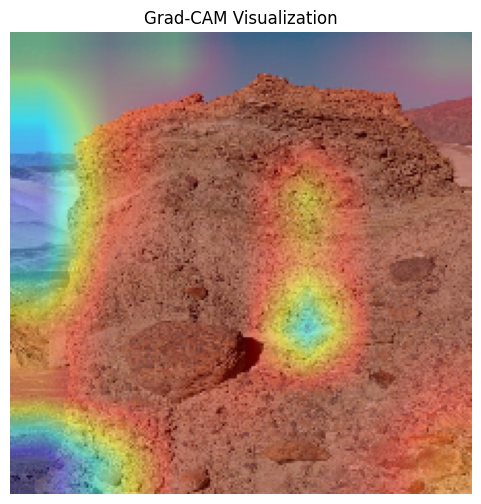

In [58]:
# Path to any validation image
img_path = "test_soil.jpg"

img, img_array = load_and_preprocess_image(img_path)

# ⚠️ For ResNet50 last conv layer
last_conv_layer_name = "conv5_block3_out"

heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name
)

display_gradcam(img, heatmap)


In [61]:
model.save("soil_resnet50_model.keras")


In [66]:
import json

with open("class_labels.json", "w") as f:
    json.dump(train_data.class_indices, f)

print("class_labels.json saved")


class_labels.json saved


In [67]:
# Load trained model
model = tf.keras.models.load_model("soil_resnet50_model.keras")

# Load class labels
with open("class_labels.json", "r") as f:
    class_labels = json.load(f)

# Reverse mapping (index → class name)
idx_to_class = {v: k for k, v in class_labels.items()}

print("Model & labels loaded successfully")


Model & labels loaded successfully


In [68]:
def preprocess_image(img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [71]:
img_path = "test_soil2.jpg"

img_array = preprocess_image(img_path)

pred = model.predict(img_array)
pred_class = idx_to_class[np.argmax(pred)]
confidence = np.max(pred)

print(f"Predicted Soil Type: {pred_class}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Soil Type: Black Soil
Confidence: 0.92
